# Comparing n data points to label scores

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [36]:
# import F1s
scores = pd.read_csv(f'/home/dveytia/ORO-map-relevance/outputs/summary_model_scores.csv')
scores = scores[['model','label name', 'F1', 'F1 macro', 'F1 - label',
                 'precision', 'precision macro', 'precision - label',
                 'recall', 'recall macro', 'recall - label']]

# combine different types of F1 scores into just one
def combine_f1(row):
    if pd.isna(row['F1 macro']) == False:
        row['F1'] = row['F1 macro']
    if pd.isna(row['F1 - label']) == False:
        row['F1'] = row['F1 - label']
    return row['F1']

scores['F1'] = scores.apply (lambda row: combine_f1(row), axis=1)


# combine different types of precision scores into just one
def combine_precision(row):
    if pd.isna(row['precision macro']) == False:
        row['precision'] = row['precision macro']
    if pd.isna(row['precision - label']) == False:
        row['precision'] = row['precision - label']
    return row['precision']

scores['precision'] = scores.apply (lambda row: combine_precision(row), axis=1)


# combine different types of recall scores into just one
def combine_recall(row):
    if pd.isna(row['recall macro']) == False:
        row['recall'] = row['recall macro']
    if pd.isna(row['recall - label']) == False:
        row['recall'] = row['recall - label']
    return row['recall']

scores['recall'] = scores.apply (lambda row: combine_recall(row), axis=1)



scores = scores[['model','label name', 'F1','precision','recall']]


print(scores.head(8))

                 model label name        F1  precision    recall
0               screen        NaN  0.702171   0.663529  0.760859
1   climate_mitigation        NaN  0.802477   0.726099  0.897321
2             Forecast        NaN  0.559951   0.466964  0.730504
3       impact_ncp.Any        NaN  0.464714   0.555556  0.414372
4        impact_nature        NaN  0.404465   0.277612  0.785101
5          blue_carbon        NaN  0.894561   0.966667  0.834936
6  biodiversity_metric        NaN  0.535073   0.508868  0.601961
7          restoration        NaN  0.605373   0.605892  0.618627


In [37]:
# For each of these labels, tabulate the number of data points


# Set up
# load in the coding dataset
codedVariablesTxt = '/home/dveytia/ORO-map-relevance/data/seen/all-coding-format-distilBERT-simplifiedMore.txt'
seen_df = pd.read_csv(codedVariablesTxt, delimiter='\t')
seen_df = seen_df.rename(columns={'analysis_id':'id'})

# Add empty column to fill with number of data points
scores['n'] = pd.Series(dtype='int') 



# Loop through the rows
for i in scores.index:
    
    # the variable and label corresponding to that row
    var = scores['model'][i]
    val = scores['label name'][i]
    
    # check if the variable name is in the columns of the data frame
    targets = [x for x in seen_df.columns if var in x]
    
    # the length of matches has to be > 0 to continue
    if len(targets) > 0:
        
        # if there are no individual labels, sum all of the columns for that variable
        if pd.isna(val) == True:
            sums = seen_df[targets].sum(axis=1) # sum
            sums.loc[sums > 1] = 1 # if > 1, set to 1
            scores.loc[[i], 'n'] = sum(sums)
                
        # if there are individual labels, subset to that column and then sum
        else:
            if var + '.' + val in seen_df:
                scores.loc[[i], 'n'] = sum(seen_df[var + '.' + val])
                
    if var == 'screen':
        screen_txt = pd.read_csv('/home/dveytia/ORO-map-relevance/data/seen/all-screen-results_screenExcl-codeIncl.txt', delimiter='\t')
        scores.loc[[i], 'n'] = len(screen_txt)
            

                 
print(scores.head(8))

                 model label name        F1  precision    recall       n
0               screen        NaN  0.702171   0.663529  0.760859  2752.0
1   climate_mitigation        NaN  0.802477   0.726099  0.897321   305.0
2             Forecast        NaN  0.559951   0.466964  0.730504   127.0
3       impact_ncp.Any        NaN  0.464714   0.555556  0.414372   134.0
4        impact_nature        NaN  0.404465   0.277612  0.785101   228.0
5          blue_carbon        NaN  0.894561   0.966667  0.834936    91.0
6  biodiversity_metric        NaN  0.535073   0.508868  0.601961   167.0
7          restoration        NaN  0.605373   0.605892  0.618627   103.0


In [38]:
# save
scores.to_csv(f'/home/dveytia/ORO-map-relevance/outputs/compare_n_to_score.csv', index=False)

## Visualize the relationship

For how to fit the model, look here: https://stackoverflow.com/questions/3433486/how-to-do-exponential-and-logarithmic-curve-fitting-in-python-i-found-only-poly

In [40]:
## Organize data
scores2 = scores[scores['n'] > 0] 
scores2 = scores2.sort_values(by=['n'])
x_data = scores2['n']
y_data = scores2['F1']

## Fit the model
def func_model(x, h):
    return x/(x+h) #return 1-np.exp(-k * x)

popt, pcov = curve_fit(func_model, x_data, y_data)


In [41]:
## Explore the results

# compute standard deviation
perr = np.sqrt(np.diag(pcov)) 
print("h = %6.2f +/- %4.2f" % (popt, perr)) 

# determination coefficient
R2 = np.sum((func_model(x_data, popt) - y_data.mean())**2) / np.sum((y_data - y_data.mean())**2)
print("r^2 = %10.6f" % R2)

h = 103.67 +/- 13.79
r^2 =   0.673845


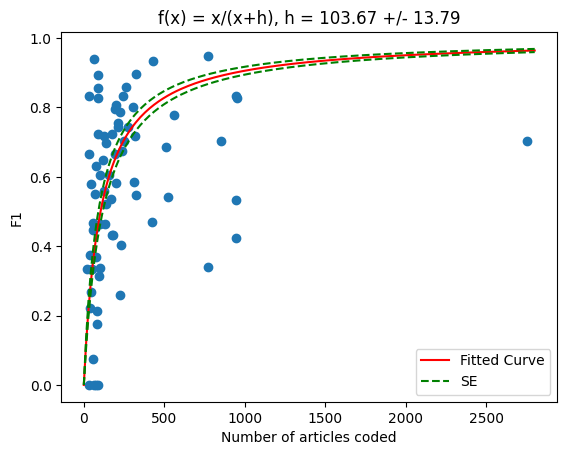

In [42]:
## Plot
plt.scatter(x_data, y_data) # original scatter

# New x values for smoother line plotting
x = np.linspace(0, 2800, 200)

# add fitted curve
plt.plot(x, func_model(x, popt), 'r-', label="Fitted Curve")

# add curves +/- se
plt.plot(x, func_model(x, popt + perr), 'g--', label = "SE")
plt.plot(x, func_model(x, popt - perr), 'g--')

plt.legend()
plt.xlabel("Number of articles coded")
plt.ylabel("F1") 
plt.title("f(x) = x/(x+h), h = %6.2f +/- %4.2f" % (popt, perr))
plt.show()

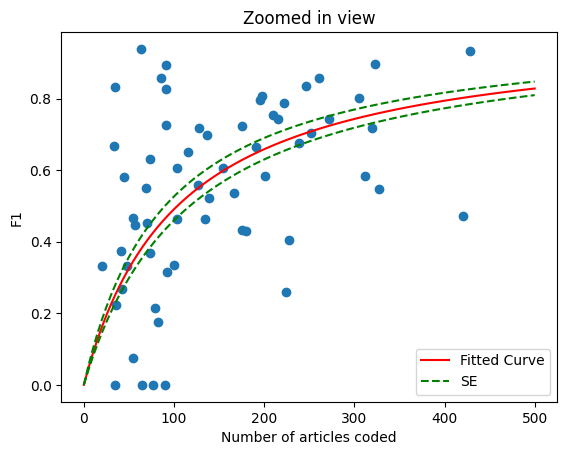

In [51]:
## Plot again, but over smaller range of n
scores3 = scores2[scores2['n'] < 500] 
x_data3 = scores3['n']
y_data3 = scores3['F1']

plt.scatter(x_data3, y_data3)


# New x values for smoother line plotting
x = np.linspace(0, 500, 100)

# add fitted curve
plt.plot(x, func_model(x, popt), 'r-', label="Fitted Curve")

# add curves +/- se
plt.plot(x, func_model(x, popt + perr), 'g--', label = "SE")
plt.plot(x, func_model(x, popt - perr), 'g--')

plt.legend()
plt.xlabel("Number of articles coded")
plt.ylabel("F1") 
plt.title("Zoomed in view")
plt.show()


## For precision

In [63]:
## Fit model
y_precision = scores2['precision']

popt_precision, pcov_precision = curve_fit(func_model, x_data, y_precision)

# compute standard deviation
perr_precision = np.sqrt(np.diag(pcov_precision)) 

## For recall

In [64]:
## Fit model
y_recall = scores2['recall']

popt_recall, pcov_recall = curve_fit(func_model, x_data, y_recall)

# compute standard deviation
perr_recall = np.sqrt(np.diag(pcov_recall))

## Combined figure

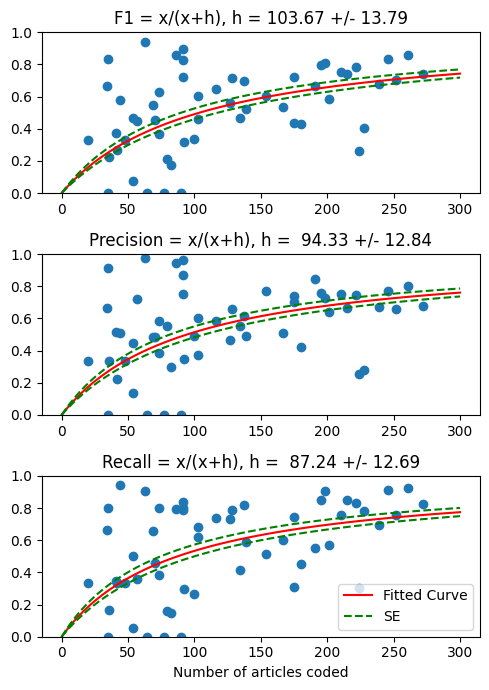

In [69]:
fig, ax = plt.subplots(3, 1, figsize=(5, 7))

maxn = 300 # the x lim

## subset data to maxn
scores3 = scores2[scores2['n'] < maxn] 
x_data3 = scores3['n']
y_data3 = scores3['F1']
y_precision3 = scores3['precision']
y_recall3 = scores3['recall']

# New x values for smoother line plotting
x = np.linspace(0, maxn, 100)



## Plot 0 -- F1
p0 = ax[0].scatter(x_data3, y_data3) # scatter
p0 = ax[0].set_title("F1 = x/(x+h), h = %6.2f +/- %4.2f" % (popt, perr)) # title
p0 = ax[0].plot(x, func_model(x, popt), 'r-', label="Fitted Curve") # fitted curve
ax[0].set_ylim(0, 1)
# add curves +/- se
ax[0].plot(x, func_model(x, popt + perr), 'g--', label = "SE")
ax[0].plot(x, func_model(x, popt - perr), 'g--')


## Plot 1 -- precision
p1 = ax[1].scatter(x_data3, y_precision3) # scatter
p1 = ax[1].set_title("Precision = x/(x+h), h = %6.2f +/- %4.2f" % (popt_precision, perr_precision)) # title
p1 = ax[1].plot(x, func_model(x, popt_precision), 'r-', label="Fitted Curve") # fitted curve
ax[1].set_ylim(0, 1)
# add curves +/- se
ax[1].plot(x, func_model(x, popt_precision + perr_precision), 'g--', label = "SE")
ax[1].plot(x, func_model(x, popt_precision - perr_precision), 'g--')



## Plot 2 -- recall
p2 = ax[2].scatter(x_data3, y_recall3) # scatter
p2 = ax[2].set_title("Recall = x/(x+h), h = %6.2f +/- %4.2f" % (popt_recall, perr_recall)) # title
p2 = ax[2].plot(x, func_model(x, popt_recall), 'r-', label="Fitted Curve") # fitted curve
ax[2].set_ylim(0, 1)
# add curves +/- se
ax[2].plot(x, func_model(x, popt_recall + perr_recall), 'g--', label = "SE")
ax[2].plot(x, func_model(x, popt_recall - perr_recall), 'g--')


# Final labels
plt.legend(loc='lower right')
plt.xlabel("Number of articles coded")


# combine
fig.tight_layout()
plt.savefig("/home/dveytia/ORO-map-relevance/figures/compare_n_to_scores.pdf", format="pdf", bbox_inches="tight")
plt.show()
